In [70]:
import os
import pyspark
import requests
import webbrowser
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.streaming import StreamingQueryException
import pandas as pd
import numpy as np

import io
import base64
import traceback

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import curdoc
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
from bokeh.plotting import figure, show
from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.palettes import Spectral10
from bokeh.transform import factor_cmap
import plotly.graph_objs as go
import plotly.express as px

from tornado.ioloop import IOLoop
from tornado.netutil import bind_sockets

from watchdog.observers import Observer
from watchdog.events import LoggingEventHandler

import mpld3

pd.set_option('display.max_colwidth', None)


In [2]:
spark = SparkSession.builder.appName("FactsSpark").enableHiveSupport().getOrCreate()
spark

In [3]:
spark.sql('''set hive.exec.dynamic.partition=true''')

spark.sql('''set hive.exec.dynamic.partition.mode=nonstrict''')


key,value
hive.exec.dynamic...,nonstrict


In [4]:
spark.sql("CREATE DATABASE IF NOT EXISTS facts")

""


In [5]:
spark.sql('''
CREATE EXTERNAL TABLE IF NOT EXISTS facts.tweet_engagement_processed (
tweet_id STRING,
like_count INT,
retweet_count INT, 
reply_count INT,
qoute_count INT,
impression_count INT,
hashtags_count INT,
media_count INT
)
LOCATION 'twitter-processed-data.tweet_engagement_processed'  ''')

""


In [6]:
spark.sql('''

INSERT INTO TABLE facts.tweet_engagement_processed
SELECT
    DISTINCT t.tweet_id,
    t.like_count,
    t.retweet_count,
    t.reply_count,
    t.qoute_count,
    t.imperssion_count,
    SIZE(t.hashtags_list),
    SIZE(t.media_ids)
FROM twitter_raw_data.tweet_data_raw t
WHERE NOT EXISTS (
    SELECT * FROM facts.tweet_engagement_processed f
    WHERE f.tweet_id = t.tweet_id )
''')

""


In [7]:
spark.sql("SELECT * FROM facts.tweet_engagement_processed").toPandas()

,tweet_id,like_count,retweet_count,reply_count,qoute_count,impression_count,hashtags_count,media_count
0,1654636587253370880,0,5290,0,0,0,0,0
1,1654636587253370880,0,5333,0,0,0,0,0
2,1654636587253370880,0,5317,0,0,0,0,0
3,1654636946873028608,0,913,0,0,0,0,0
4,1654636946873028608,0,657,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2594,1653910994572439552,2,1,2,0,1,0,1
2595,1653911370201731075,0,79,0,0,0,0,0
2596,1653912092963926017,0,24412,0,0,0,0,0
2597,1653912262283874307,1,0,0,0,19,1,0


In [8]:
spark.sql('''
CREATE EXTERNAL TABLE IF NOT EXISTS facts.user_activity_processed (
user_id STRING,
tweet_count INT,
followers_count INT, 
following_count INT
)
LOCATION 'twitter-processed-data.user_activity_processed'  ''')

""


In [9]:
spark.sql('''

INSERT INTO TABLE facts.user_activity_processed
SELECT
    DISTINCT u.user_id,
    u.tweet_count,
    u.followers_count,
    u.following_count
FROM twitter_raw_data.user_data_raw u
WHERE NOT EXISTS (
    SELECT * FROM facts.user_activity_processed f
    WHERE f.user_id = u.user_id )
''')

""


In [10]:
spark.sql("SELECT * FROM facts.user_activity_processed").toPandas()

,user_id,tweet_count,followers_count,following_count
0,121861357,9870.0,2582.0,3025.0
1,832348269040762882,35907.0,654.0,275.0
2,832348269040762882,35899.0,654.0,275.0
3,1042237547802505216,87284.0,214.0,512.0
4,1578152434408595461,78.0,32.0,630.0
...,...,...,...,...
2208,1082857430873042945,6108.0,30.0,159.0
2209,1082857430873042945,6111.0,30.0,159.0
2210,1635339329445699598,746.0,231.0,416.0
2211,798034514,441271.0,3612.0,5202.0


In [11]:
spark.sql('''
CREATE EXTERNAL TABLE IF NOT EXISTS facts.users_tweets_processed (
tweet_id STRING,
user_id STRING,
num_hashtags INT,
num_media INT
)
LOCATION 'twitter-processed-data.users_tweets_processed'  ''')

""


In [12]:
spark.sql('''
INSERT INTO TABLE facts.users_tweets_processed
SELECT
    t.tweet_id,
    u.user_id,
    size(t.hashtags_list) as num_hashtags,
  sum(case when m.media_id is not null then 1 else 0 end) as num_media
FROM twitter_raw_data.tweet_data_raw t
LEFT JOIN twitter_raw_data.user_data_raw u ON t.author_id = u.user_id
LEFT JOIN twitter_raw_data.media_data_raw m ON array_contains(t.media_ids, m.media_id)
GROUP BY
 t.tweet_id,
 t.hashtags_list,
 u.user_id,
 m.media_id
''')

""


In [13]:
spark.sql("SELECT * FROM facts.users_tweets_processed").toPandas()

,tweet_id,user_id,num_hashtags,num_media
0,1653911079322537984,3165214950,NaN,NaN
1,1653912117660229632,1440744771165687809,NaN,NaN
2,1654274520931528704,1082857430873042945,NaN,NaN
3,1653911962114203649,1639769861457866752,NaN,NaN
4,1654272361934274560,1394859094784233473,NaN,NaN
...,...,...,...,...
3449,1654636731986001922,1646478567943839746,4.0,3.0
3450,1654636686654189569,1049264159894851584,0.0,3.0
3451,1653912019400048641,1027615651043713025,2.0,1.0
3452,1654274478178996224,1489701364418572288,0.0,0.0


In [12]:
spark.sql('''
CREATE EXTERNAL TABLE IF NOT EXISTS facts.totals_mertics_processed (
tweet_id STRING,
user_id STRING,
place_id STRING,
media_id STRING,
count_weekend_tweets INT,
count_week_tweets INT,
verified_user_count INT,
protected_user_count INT,
high_popularity_user_count INT,
middle_popularity_user_count INT,
low_popularity_user_count INT,
photo_media_count INT,
video_media_count INT,
city_count INT,
limited_reply_tweet_count INT
)
LOCATION 'twitter-processed-data.totals_mertics_processed'  ''')

""


In [13]:
spark.sql('''
INSERT INTO TABLE facts.totals_mertics_processed
SELECT
    null as tweet_id,
    null as user_id,
    null as place_id,
    null as media_id,
    COUNT(DISTINCT CASE WHEN dayofweek(from_unixtime(UNIX_TIMESTAMP(t.tweet_date, 'yyyy-MM-dd HH:mm:ss'))) in (6,7) THEN t.tweet_id END) AS count_weekend_tweets,
    COUNT(DISTINCT CASE WHEN dayofweek(from_unixtime(UNIX_TIMESTAMP(t.tweet_date, 'yyyy-MM-dd HH:mm:ss'))) not in (6,7) THEN t.tweet_id END) AS count_week_tweets,
    COUNT(DISTINCT CASE WHEN u.verfied = true THEN u.user_id ELSE NULL END) AS verified_user_count,
    COUNT(DISTINCT CASE WHEN u.protected = true THEN u.user_id ELSE NULL END) AS protected_user_count,
    COUNT(DISTINCT CASE WHEN u.user_popularity = 'High' THEN u.user_id ELSE NULL END) AS high_popularity_user_count,
    COUNT(DISTINCT CASE WHEN u.user_popularity = 'Middle' THEN u.user_id ELSE NULL END) AS middle_popularity_user_count,
    COUNT(DISTINCT CASE WHEN u.user_popularity = 'Low' THEN u.user_id ELSE NULL END) AS low_popularity_user_count,
    COUNT(DISTINCT CASE WHEN m.media_type = 'photo' THEN m.media_id ELSE NULL END) AS photo_media_count,
    COUNT(DISTINCT CASE WHEN m.media_type = 'video' THEN m.media_id ELSE NULL END) AS video_media_count,
    COUNT(DISTINCT CASE WHEN p.place_type = 'city' THEN p.place_id ELSE NULL END) AS city_count,
    COUNT(DISTINCT CASE WHEN t.who_can_reply != 'everyone' THEN t.tweet_id ELSE NULL END) AS limited_reply_tweet_count
FROM
    twitter_raw_data.tweet_data_raw t
    LEFT JOIN twitter_raw_data.user_data_raw u ON t.author_id = u.user_id
    LEFT JOIN twitter_raw_data.media_data_raw m ON array_contains(t.media_ids, m.media_id)
    LEFT JOIN twitter_raw_data.place_data_raw p ON t.tweet_location = p.place_id
''')

""


In [14]:
spark.sql("SELECT * FROM facts.totals_mertics_processed").toPandas()

,tweet_id,user_id,place_id,media_id,count_weekend_tweets,count_week_tweets,verified_user_count,protected_user_count,high_popularity_user_count,middle_popularity_user_count,low_popularity_user_count,photo_media_count,video_media_count,city_count,limited_reply_tweet_count
0,None,None,None,None,499,985,53,0,117,250,971,200,65,4,28


In [14]:
hash_df = spark.sql("SELECT hashtags_list FROM twitter_raw_data.tweet_data_raw WHERE SIZE(hashtags_list) > 0")

In [15]:
hash_counts = (
    hash_df.select(explode("hashtags_list").alias("hashtag"))
      .groupBy("hashtag")
      .agg(count("*").alias("count"))
)

In [16]:
print(hash_counts)

+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|     #bettertogether|    1|
|      #drinksforkids|    2|
|    #criminaljustice|    1|
|       #TwitterSpace|   20|
|              #cypto|    1|
|#RealEstateRecrui...|    1|
|   #driverseducation|    2|
|               #100X|    1|
|               #hope|    1|
|         #femboycdmx|    4|
|          #beautiful|    5|
|  #AITCMakesitHappen|    1|
|          #avmapping|    1|
|          #economics|    2|
|#ConstructionSafe...|    3|
|          #Engineeri|    2|
|         #artificial|    3|
|                #LFC|    1|
|         #seniorcare|    1|
|                #OTD|    2|
+--------------------+-----+
only showing top 20 rows



In [17]:
#hash_counts_dict = dict(hash_counts.rdd.map(lambda row: (row["hashtag"], row["count"])).collect())

top_hash = hash_counts.orderBy("count", ascending=False).limit(10).collect()

In [18]:
print(top_hash)

[Row(hashtag='#NBA', count=103), Row(hashtag='#JordanNeely', count=100), Row(hashtag='#TigrayGenocide', count=78), Row(hashtag='#grindfacetv', count=50), Row(hashtag='#technology', count=48), Row(hashtag='#AI', count=47), Row(hashtag='#Bitcoin', count=25), Row(hashtag='#bugbounty', count=24), Row(hashtag='#California', count=23), Row(hashtag='#gasprices', count=22)]


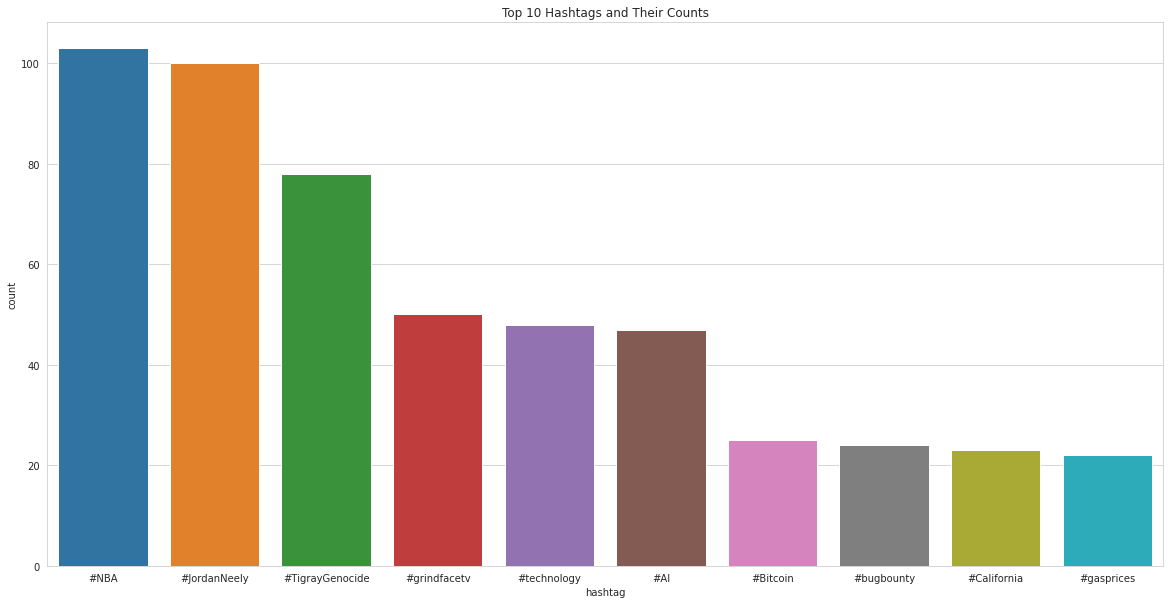

In [19]:
# Convert top_hash to a Spark DataFrame
top_hash_df = spark.createDataFrame(top_hash)

# Convert to a Pandas DataFrame
top_hash_pd = top_hash_df.toPandas()

# Set up the chart
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.title("Top 10 Hashtags and Their Counts")
plt.xlabel("Hashtag")
plt.ylabel("Count")

# Plot the data
sns.barplot(x="hashtag", y="count", data=top_hash_pd)

# Show the chart
plt.show()

In [7]:
popular_users = spark.table("twitter_raw_data.user_data_raw") \
    .select("username", col("followers_count").cast("int")) \
    .groupBy("username") \
    .agg({"followers_count": "max"}) \
    .withColumnRenamed("max(followers_count)", "followers_count") \
    .orderBy(desc("followers_count")) \
    .limit(10) \
    .toPandas()

In [8]:
popular_users

,username,followers_count
0,okezonenews,1848689
1,DiscoverMag,1255317
2,KicksDeals,472038
3,EvanKirstel,345254
4,Movie__01,328489
5,ADB_HQ,258222
6,Doutporn,224000
7,machinelearnflx,157760
8,DataScienceDojo,144693
9,DeAngelisCorey,136956


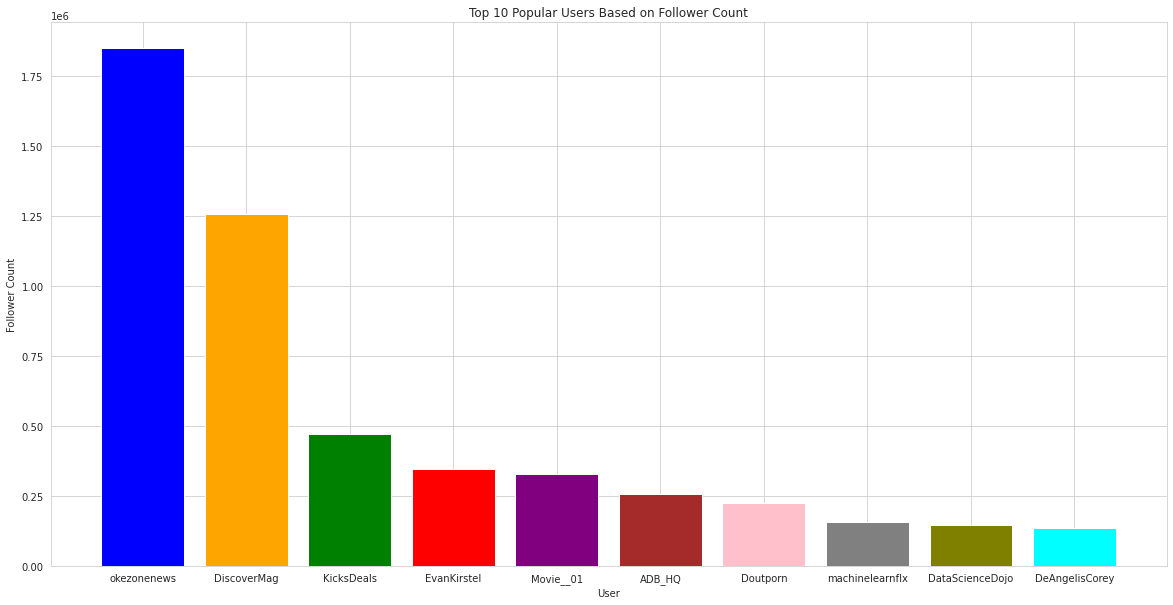

In [9]:
# Set up the chart
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.title("Top 10 Popular Users Based on Follower Count")
plt.xlabel("User")
plt.ylabel("Follower Count")

# Define a list of colors for the columns
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot the data
plt.bar(popular_users["username"], popular_users["followers_count"], color=colors)

# Show the chart
plt.show()

In [42]:
# Convert tweet_data_raw to a Spark DataFrame
tweet_data = spark.sql("SELECT date_format(from_unixtime(UNIX_TIMESTAMP(tweet_date, 'yyyy-MM-dd HH:mm:ss')), 'EEEE') as week_day FROM twitter_raw_data.tweet_data_raw")


# Group by week_day and count the number of tweets
tweet_counts = tweet_data.groupBy("week_day").count()

# Convert to a Pandas DataFrame
tweet_counts_pd = tweet_counts.toPandas()

In [43]:
tweet_counts_pd

,week_day,count
0,Wednesday,626
1,Friday,946
2,Thursday,1027


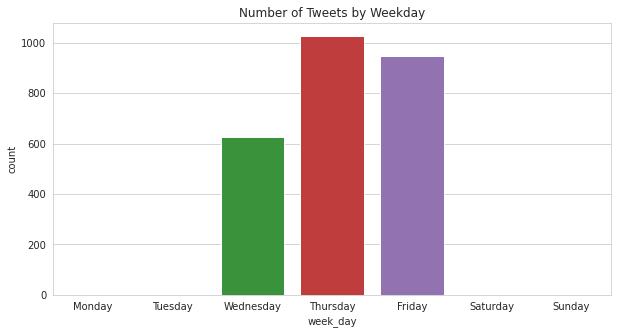

In [44]:
# Define the order of weekdays
weekdays_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert to a Pandas DataFrame
tweet_counts_pd = tweet_counts.toPandas()

# Create the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plt.title("Number of Tweets by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Tweets")
sns.barplot(x=tweet_counts_pd["week_day"], y=tweet_counts_pd["count"], order=weekdays_order)
plt.show()

In [49]:
media_counts = spark.sql("SELECT media_type, COUNT(media_type) as count FROM twitter_raw_data.media_data_raw WHERE media_type != 'NaN' GROUP BY media_type")

In [50]:
media_counts

media_type,count
video,65
photo,200
animated_gif,9


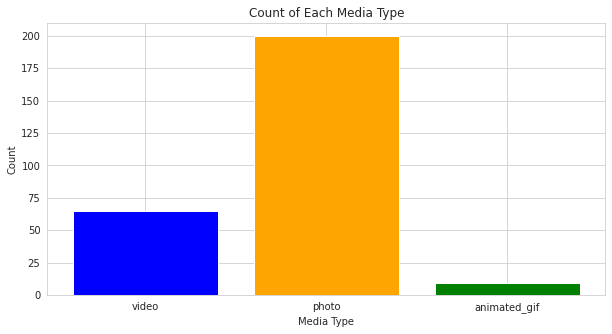

In [51]:
# Set up the chart
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plt.title("Count of Each Media Type")
plt.xlabel("Media Type")
plt.ylabel("Count")

# Define the colors for the bars
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Convert count column to a list
count_list = media_counts.select("count").rdd.flatMap(lambda x: x).collect()

# Plot the data
plt.bar(media_counts.select("media_type").rdd.flatMap(lambda x: x).collect(), count_list, color=colors)

# Show the chart
plt.show()

In [61]:
# Read the data from Hive table into a Pandas DataFrame
user_data_raw_df = spark.sql("SELECT user_popularity, COUNT(*) AS count FROM twitter_raw_data.user_data_raw WHERE user_popularity != 'null' GROUP BY user_popularity")

In [62]:
user_data_raw_df

user_popularity,count
High,242
Low,1567
Middle,416


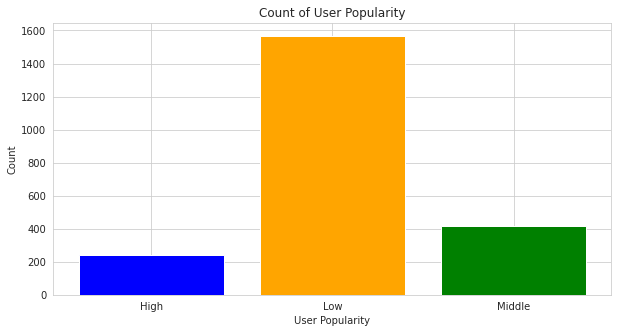

In [63]:
# Set up the chart
plt.figure(figsize=(10, 5))
plt.title("Count of User Popularity")
plt.xlabel("User Popularity")
plt.ylabel("Count")

# Define the colors for the bars
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Convert count column to a list
count_list = user_data_raw_df.select("count").rdd.flatMap(lambda x: x).collect()


# Plot the data
plt.bar(user_data_raw_df.select("user_popularity").rdd.flatMap(lambda x: x).collect(), count_list, color=colors)

# Show the chart
plt.show()

In [67]:
# Create a Bokeh figure for the first chart
top_hash_pd_source = ColumnDataSource(top_hash_pd)
p1 = figure(x_range=top_hash_pd["hashtag"], plot_height=500, plot_width=1000, title="Top 10 Hashtags and Their Counts")
p1.vbar(x="hashtag", top="count", width=0.9, source=top_hash_pd_source, line_color="white", fill_color=factor_cmap('hashtag', palette=Spectral10, factors=top_hash_pd['hashtag']))

# Add hover tool
hover = HoverTool(tooltips=[("Hashtag", "@hashtag"), ("Count", "@count")])
p1.add_tools(hover)


# Create a Bokeh figure for the second chart
popular_users_source = ColumnDataSource(popular_users)
p2 = figure(x_range=popular_users["username"], plot_height=500, plot_width=1000, title="Top 10 Popular Users Based on Follower Count")
p2.vbar(x="username", top="followers_count", width=0.9, source=popular_users_source, line_color="white", fill_color=factor_cmap('username', palette=Spectral10, factors=popular_users['username']))

# Format y-axis ticks as thousands
p2.yaxis.formatter = NumeralTickFormatter(format='0.0a')


# Add hover tool
hover = HoverTool(tooltips=[("Username", "@username"), ("Follower Count", "@followers_count")])
p2.add_tools(hover)



# Create a Bokeh figure for the third chart
p3 = figure(x_range=weekdays_order, plot_height=500, plot_width=1000, title="Number of Tweets by Weekday")
p3.vbar(x="week_day", top="count", width=0.9, source=tweet_counts_pd, line_color="white", fill_color=factor_cmap('week_day', palette=Spectral10, factors=weekdays_order))

# Add hover tool
hover = HoverTool(tooltips=[("Weekday", "@week_day"), ("Count", "@count")])
p3.add_tools(hover)


# Create a Bokeh figure for the forth chart
media_counts_pd_source = ColumnDataSource(media_counts.toPandas())
p4 = figure(x_range=media_counts_pd_source.data["media_type"], plot_height=500, plot_width=1000, title="Count of Each Media Type")
p4.vbar(x="media_type", top="count", width=0.9, source=media_counts_pd_source, line_color="white", fill_color=factor_cmap('media_type', palette=colors, factors=media_counts_pd_source.data["media_type"]))

# Add hover tool
hover = HoverTool(tooltips=[("Media Type", "@media_type"), ("Count", "@count")])
p4.add_tools(hover)



# Create a Bokeh figure for the fifth chart
user_data_pd = user_data_raw_df.toPandas()

# Create a Bokeh figure
user_data_source = ColumnDataSource(user_data_pd)
p5 = figure(x_range=user_data_pd["user_popularity"], plot_height=500, plot_width=1000, title="Count of User Popularity")
p5.vbar(x="user_popularity", top="count", width=0.9, source=user_data_source, line_color="white", fill_color=factor_cmap('user_popularity', palette=Spectral10, factors=user_data_pd['user_popularity']))

# Add hover tool
hover = HoverTool(tooltips=[("User Popularity", "@user_popularity"), ("Count", "@count")], formatters={'@count': 'printf'})
p5.add_tools(hover)




In [68]:
# Create a grid layout for the charts
layout = gridplot([[p1], [p2], [p3], [p4],[p5]])

In [75]:
# Save the Bokeh figures to an HTML file
from bokeh.resources import CDN
from bokeh.embed import file_html
html = file_html(layout, CDN, "Twitter Charts")
with open("twitter_charts.html", "w") as f:
    f.write(html)

In [77]:
# Open the file in a new browser window
webbrowser.open_new_tab('twitter_charts.html')

False

In [78]:
# Refresh the page every 5 minutes
while True:
    time.sleep(300)
    webbrowser.open('twitter_charts.html', new=0)
    #webbrowser.get('chrome').open_new_tab('twitter_charts.html')

KeyboardInterrupt: 